<a href="https://colab.research.google.com/github/philipododo/philipododo.github.io/blob/main/multileg_options_strategy_with_dynamic_expirtaion_team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optionlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.7/922.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: holidays
    Found existing installation: holidays 0.73
    Uninstalling holidays-0.73:
      Successfully uninstalled holidays-0.73
  Attempting uninstall: 

In [2]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from optionlab import run_strategy, plot_pl
%matplotlib inline

In [3]:
# for interactive tables
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [4]:
# load option chain dataset for team 1
fcsv = "https://raw.githubusercontent.com/multidis/hult-options-trading/refs/heads/main/option_chain_data/2025-03-25_option_chain_120days_team1.csv"
df = pd.read_csv(fcsv)

In [7]:
# to convert expiration date and filter
df['expiration_date'] = pd.to_datetime(df['expiration_date'])

# to remove missing rows with missing values calculate midpoint price
df = df[df['expiration_date'] >= pd.Timestamp('2025-06-01')]
df = df.dropna(subset=['bid', 'ask', 'mid_iv', 'delta', 'gamma', 'theta', 'vega']).copy()
df['mid_price'] = (df['bid'] + df['ask']) / 2

In [8]:
# estimate underlying price from ATM call delta ≈ 0.5
atm_calls = df[df['option_type'] == 'call'].copy()
atm_calls['delta_diff'] = abs(atm_calls['delta'] - 0.5)
atm_call = atm_calls.loc[atm_calls['delta_diff'].idxmin()]
underlying_price = atm_call['strike'] + atm_call['mid_price']
underlying_price

np.float64(289.825)

In [11]:
# common setup
dfchain = df.copy()
start_date = date.today()
volatility = 0.25
interest_rate = 0.05
atm_strike = round(underlying_price / 5) * 5
spread = 5
dfchain = df.copy()
min_stock = float(underlying_price - 30)
max_stock = float(underlying_price + 30)

def get_index(strike, option_type, expiration):
    return dfchain[
        (dfchain['strike'] == strike) &
        (dfchain['option_type'] == option_type) &
        (dfchain['expiration_date'] == pd.Timestamp(expiration))
    ].index[0]

##Bull Put Spread (Bullish)






Profit/Loss diagram:
--------------------
The vertical green dashed line corresponds to the position of the stock's spot price. The right and left arrow markers indicate the strike prices of calls and puts, respectively, with blue representing long and red representing short positions.
Probability of profit: 0.5838489375519347
Profit ranges: [(285.96, inf)]
Per leg cost: [1330.0, -1025.0]
Strategy cost: 305.0
Minimum return in the domain: -195.0
Maximum return in the domain: 305.0
Implied volatility: [0.44, 0.418]
In the money probability: [0.4754393249482755, 0.3785072541429466]
Delta: [0.44747911653133354, -0.352034635546998]
Gamma: [0.019374657002040222, 0.018184064058883568]
Theta: [0.17466148815161897, -0.1681699067108191]
Vega: [0.32290530149498925, 0.30306243288434387]
Rho: [0.10861730113099746, -0.08497645536758325]



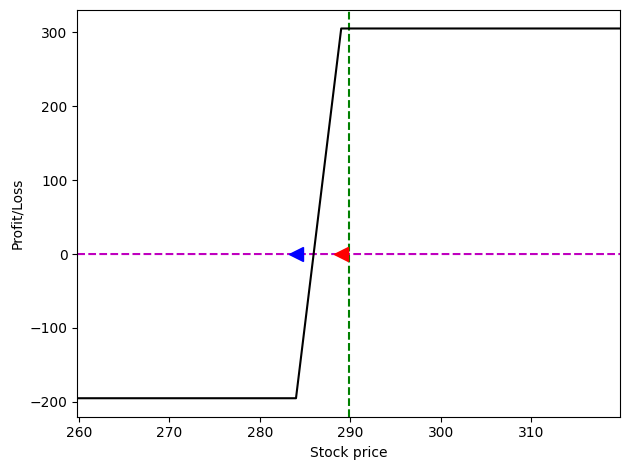

In [13]:
# use mid-term expiry (30–60 days)
exp_bull = df[df['option_type'] == 'put']['expiration_date'].drop_duplicates()
exp_bull = exp_bull[exp_bull >= pd.Timestamp('2025-06-30')].min().date()
short_strike = atm_strike - 1
long_strike = short_strike - spread
isell = get_index(short_strike, 'put', exp_bull)
ibuy = get_index(long_strike, 'put', exp_bull)
bull_put = {
    'strategy': [
        {'type': 'put', 'strike': float(dfchain.loc[isell, 'strike']), 'premium': float(dfchain.loc[isell, 'bid']), 'n': 100, 'action': 'sell', 'expiration': exp_bull},
        {'type': 'put', 'strike': float(dfchain.loc[ibuy, 'strike']), 'premium': float(dfchain.loc[ibuy, 'ask']), 'n': 100, 'action': 'buy', 'expiration': exp_bull}
    ],
    'stock_price': float(underlying_price), 'volatility': volatility, 'interest_rate': interest_rate,
    'min_stock': min_stock, 'max_stock': max_stock, 'start_date': start_date, 'target_date': exp_bull
}
bp = run_strategy(bull_put)
plot_pl(bp)
print(bp)

##**Bull Call Spread (Bullish)**

Profit/Loss diagram:
--------------------
The vertical green dashed line corresponds to the position of the stock's spot price. The right and left arrow markers indicate the strike prices of calls and puts, respectively, with blue representing long and red representing short positions.
Probability of profit: 0.4765775794311573
Profit ranges: [(291.46, inf)]
Per leg cost: [-480.0, 335.0]
Strategy cost: -145.0
Minimum return in the domain: -145.0
Maximum return in the domain: 355.0000000000002
Implied volatility: [0.132, 0.156]
In the money probability: [0.5050098471409081, 0.4089842182338711]
Delta: [0.5330693304516616, -0.4365471989540066]
Gamma: [0.019477086904708035, 0.019296534354197138]
Theta: [-0.23182579774855244, 0.22484580442476973]
Vega: [0.3246124366767667, 0.32160328014035566]
Rho: [0.115772099302293, -0.09537501734818964]



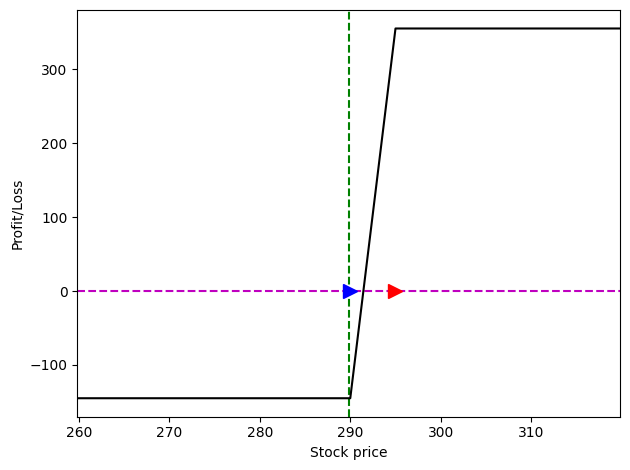

In [16]:
#bull call spread
exp_list = df['expiration_date'].drop_duplicates().sort_values()
expiry_bull_call = exp_list[exp_list >= pd.Timestamp("2025-06-30")].min().date()

long_strike_bc = atm_strike
short_strike_bc = atm_strike + 5

ibuy_bc = df[
    (df["option_type"] == "call") &
    (df["strike"] == long_strike_bc) &
    (df["expiration_date"].dt.date == expiry_bull_call)
].index[0]

isell_bc = df[
    (df["option_type"] == "call") &
    (df["strike"] == short_strike_bc) &
    (df["expiration_date"].dt.date == expiry_bull_call)
].index[0]

bull_call = {
    "strategy": [
        {
            "type": "call",
            "strike": float(dfchain.loc[ibuy_bc, "strike"]),
            "premium": float(dfchain.loc[ibuy_bc, "ask"]),
            "n": 100,
            "action": "buy",
            "expiration": expiry_bull_call
        },
        {
            "type": "call",
            "strike": float(dfchain.loc[isell_bc, "strike"]),
            "premium": float(dfchain.loc[isell_bc, "bid"]),
            "n": 100,
            "action": "sell",
            "expiration": expiry_bull_call
        }
    ],
    "stock_price": float(underlying_price),
    "volatility": volatility,
    "interest_rate": interest_rate,
    "min_stock": float(underlying_price - 30),
    "max_stock": float(underlying_price + 30),
    "start_date": date.today(),
    "target_date": expiry_bull_call
}

bc = run_strategy(bull_call)
plot_pl(bc)
print(bc)

##Bear Put Spread (Bearish)

Profit/Loss diagram:
--------------------
The vertical green dashed line corresponds to the position of the stock's spot price. The right and left arrow markers indicate the strike prices of calls and puts, respectively, with blue representing long and red representing short positions.
Probability of profit: 0.5133183825453342
Profit ranges: [(0.0, 290.94)]
Per leg cost: [-1805.0, 1400.0]
Strategy cost: -405.0
Minimum return in the domain: -405.0
Maximum return in the domain: 95.0
Implied volatility: [0.487, 0.446]
In the money probability: [0.5910157817661289, 0.4949901528590918]
Delta: [-0.5634528010459934, 0.4669306695483384]
Gamma: [0.019296534354197138, 0.019477086904708035]
Theta: [-0.16654586698460977, 0.17451399484127658]
Vega: [0.32160328014035566, 0.3246124366767667]
Rho: [-0.13782473241245013, 0.11347511232681054]



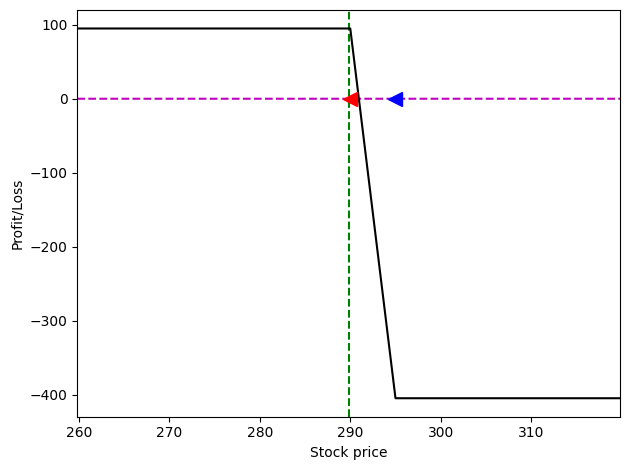

In [17]:
exp_bear = df[df['option_type'] == 'put']['expiration_date'].drop_duplicates()
exp_bear = exp_bear[exp_bear >= pd.Timestamp('2025-06-30')].min().date()
long_strike = atm_strike + 5
short_strike = long_strike - spread
ibuy = get_index(long_strike, 'put', exp_bear)
isell = get_index(short_strike, 'put', exp_bear)
bear_put = {
    'strategy': [
        {'type': 'put', 'strike': float(dfchain.loc[ibuy, 'strike']), 'premium': float(dfchain.loc[ibuy, 'ask']), 'n': 100, 'action': 'buy', 'expiration': exp_bear},
        {'type': 'put', 'strike': float(dfchain.loc[isell, 'strike']), 'premium': float(dfchain.loc[isell, 'bid']), 'n': 100, 'action': 'sell', 'expiration': exp_bear}
    ],
    'stock_price': float(underlying_price), 'volatility': volatility, 'interest_rate': interest_rate,
    'min_stock': min_stock, 'max_stock': max_stock, 'start_date': start_date, 'target_date': exp_bear
}
br = run_strategy(bear_put)
plot_pl(br)
print(br)

## Bear Call Spread (Berish)

Profit/Loss diagram:
--------------------
The vertical green dashed line corresponds to the position of the stock's spot price. The right and left arrow markers indicate the strike prices of calls and puts, respectively, with blue representing long and red representing short positions.
Probability of profit: 0.5191512974649937
Profit ranges: [(0.0, 291.24)]
Per leg cost: [470.0, -345.0]
Strategy cost: 125.0
Minimum return in the domain: -375.0000000000002
Maximum return in the domain: 125.0
Implied volatility: [0.129, 0.159]
In the money probability: [0.5050098471409081, 0.4089842182338711]
Delta: [-0.5330693304516616, 0.4365471989540066]
Gamma: [0.019477086904708035, 0.019296534354197138]
Theta: [0.23182579774855244, -0.22484580442476973]
Vega: [0.3246124366767667, 0.32160328014035566]
Rho: [-0.115772099302293, 0.09537501734818964]



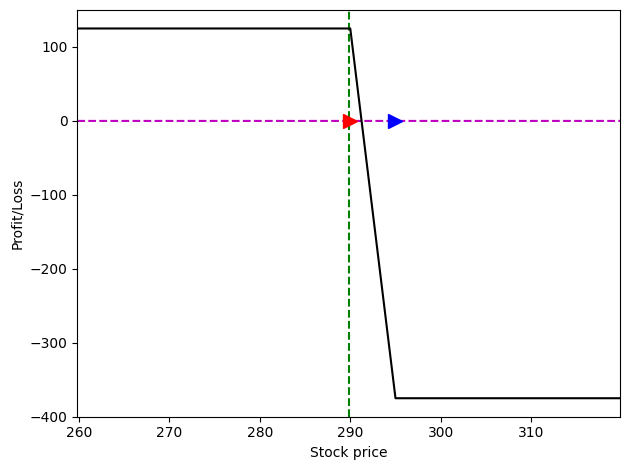

In [18]:
expiry_bear_call = expiry_bull_call

short_strike_brc = atm_strike
long_strike_brc = atm_strike + 5

isell_bear = df[
    (df["option_type"] == "call") &
    (df["strike"] == short_strike_brc) &
    (df["expiration_date"].dt.date == expiry_bear_call)
].index[0]

ibuy_bear = df[
    (df["option_type"] == "call") &
    (df["strike"] == long_strike_brc) &
    (df["expiration_date"].dt.date == expiry_bear_call)
].index[0]

bear_call = {
    "strategy": [
        {
            "type": "call",
            "strike": float(dfchain.loc[isell_bear, "strike"]),
            "premium": float(dfchain.loc[isell_bear, "bid"]),
            "n": 100,
            "action": "sell",
            "expiration": expiry_bear_call
        },
        {
            "type": "call",
            "strike": float(dfchain.loc[ibuy_bear, "strike"]),
            "premium": float(dfchain.loc[ibuy_bear, "ask"]),
            "n": 100,
            "action": "buy",
            "expiration": expiry_bear_call
        }
    ],
    "stock_price": float(underlying_price),
    "volatility": volatility,
    "interest_rate": interest_rate,
    "min_stock": float(underlying_price - 30),
    "max_stock": float(underlying_price + 30),
    "start_date": date.today(),
    "target_date": expiry_bear_call
}

brc = run_strategy(bear_call)
plot_pl(brc)
print(brc)

##Iron Condor (Neutral, Range Bound)

Profit/Loss diagram:
--------------------
The vertical green dashed line corresponds to the position of the stock's spot price. The right and left arrow markers indicate the strike prices of calls and puts, respectively, with blue representing long and red representing short positions.
Probability of profit: 0.32417842263200264
Profit ranges: [(281.46, 298.54)]
Per leg cost: [1070.0, -805.0000000000001, 335.0, -244.0]
Strategy cost: 355.9999999999999
Minimum return in the domain: -144.00000000000023
Maximum return in the domain: 355.9999999999999
Implied volatility: [0.418, 0.4, 0.156, 0.177]
In the money probability: [0.3976261279331693, 0.30474363960637685, 0.4089842182338711, 0.3196076838669671]
Delta: [0.3707279667291159, -0.2805410441548798, -0.4365471989540066, 0.3451799845550106]
Gamma: [0.01850899190836155, 0.0165066802789231, 0.019296534354197138, 0.018053403824740185]
Theta: [0.1704028642782869, -0.1550784265054498, 0.22484580442476973, -0.2070019236194424]
Vega: [0.308477802

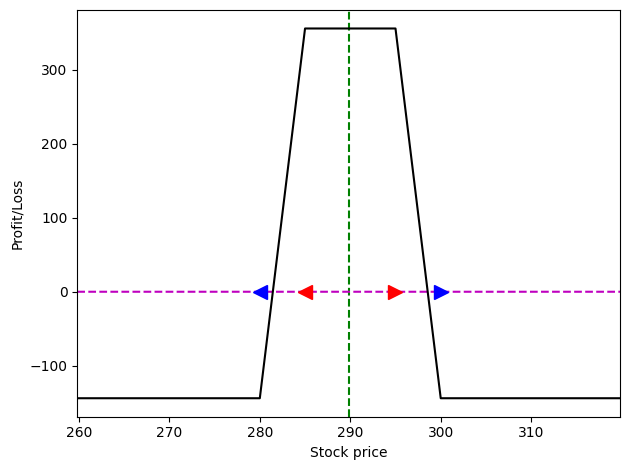

In [19]:
exp_ic = df[df['option_type'] == 'put']['expiration_date'].drop_duplicates().max().date()
put_sell = atm_strike - 5
put_buy = put_sell - spread
call_sell = atm_strike + 5
call_buy = call_sell + spread
iron_condor = {
    'strategy': [
        {'type': 'put', 'strike': float(dfchain.loc[get_index(put_sell, 'put', exp_ic), 'strike']), 'premium': float(dfchain.loc[get_index(put_sell, 'put', exp_ic), 'bid']), 'n': 100, 'action': 'sell', 'expiration': exp_ic},
        {'type': 'put', 'strike': float(dfchain.loc[get_index(put_buy, 'put', exp_ic), 'strike']), 'premium': float(dfchain.loc[get_index(put_buy, 'put', exp_ic), 'ask']), 'n': 100, 'action': 'buy', 'expiration': exp_ic},
        {'type': 'call', 'strike': float(dfchain.loc[get_index(call_sell, 'call', exp_ic), 'strike']), 'premium': float(dfchain.loc[get_index(call_sell, 'call', exp_ic), 'bid']), 'n': 100, 'action': 'sell', 'expiration': exp_ic},
        {'type': 'call', 'strike': float(dfchain.loc[get_index(call_buy, 'call', exp_ic), 'strike']), 'premium': float(dfchain.loc[get_index(call_buy, 'call', exp_ic), 'ask']), 'n': 100, 'action': 'buy', 'expiration': exp_ic}
    ],
    'stock_price': float(underlying_price), 'volatility': volatility, 'interest_rate': interest_rate,
    'min_stock': min_stock, 'max_stock': max_stock, 'start_date': start_date, 'target_date': exp_ic
}
ic = run_strategy(iron_condor)
plot_pl(ic)
print(ic)

##Straddle (Volatility Bet)

Profit/Loss diagram:
--------------------
The vertical green dashed line corresponds to the position of the stock's spot price. The right and left arrow markers indicate the strike prices of calls and puts, respectively, with blue representing long and red representing short positions.
Probability of profit: 0.2834581302163424
Profit ranges: [(0.0, 271.68), (308.32, inf)]
Per leg cost: [-434.99999999999994, -1395.0]
Strategy cost: -1830.0
Minimum return in the domain: -1830.0
Maximum return in the domain: 1188.0000000000007
Implied volatility: [0.148, 0.524]
In the money probability: [0.5029655985102831, 0.4970344014897169]
Delta: [0.5264541083615808, -0.4735458916384192]
Gamma: [0.023308495685935265, 0.023308495685935265]
Theta: [-0.2716527851156361, -0.2142727132433399]
Vega: [0.27192769287468244, 0.27192769287468244]
Rho: [0.08080856613707504, -0.0798556351053543]



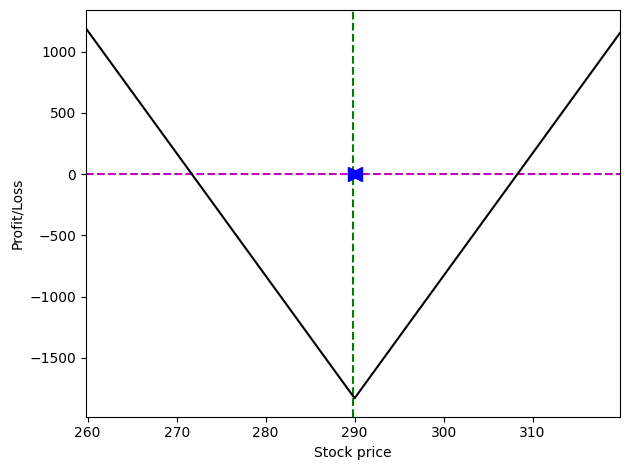

In [20]:
exp_straddle = df[df['option_type'] == 'call']['expiration_date'].drop_duplicates().min().date()
istraddle_call = get_index(atm_strike, 'call', exp_straddle)
istraddle_put = get_index(atm_strike, 'put', exp_straddle)
straddle = {
    'strategy': [
        {'type': 'call', 'strike': float(dfchain.loc[istraddle_call, 'strike']), 'premium': float(dfchain.loc[istraddle_call, 'ask']), 'n': 100, 'action': 'buy', 'expiration': exp_straddle},
        {'type': 'put', 'strike': float(dfchain.loc[istraddle_put, 'strike']), 'premium': float(dfchain.loc[istraddle_put, 'ask']), 'n': 100, 'action': 'buy', 'expiration': exp_straddle}
    ],
    'stock_price': float(underlying_price), 'volatility': volatility, 'interest_rate': interest_rate,
    'min_stock': min_stock, 'max_stock': max_stock, 'start_date': start_date, 'target_date': exp_straddle
}
sd = run_strategy(straddle)
plot_pl(sd)
print(sd)

##Strangle (Volatility Bet, OTM)

Profit/Loss diagram:
--------------------
The vertical green dashed line corresponds to the position of the stock's spot price. The right and left arrow markers indicate the strike prices of calls and puts, respectively, with blue representing long and red representing short positions.
Probability of profit: 0.27461974176180026
Profit ranges: [(0.0, 271.34), (308.66, inf)]
Per leg cost: [-305.0, -1060.0]
Strategy cost: -1365.0
Minimum return in the domain: -1365.0
Maximum return in the domain: 1153.0000000000007
Implied volatility: [0.179, 0.49]
In the money probability: [0.38871550849917813, 0.3811044521668872]
Delta: [0.41147869404924586, -0.3588602561040424]
Gamma: [0.02278242164108237, 0.02188225548783122]
Theta: [-0.2600018253857467, -0.20644540426779176]
Vega: [0.2657902697125166, 0.2552885149637034]
Rho: [0.0635294367987991, -0.06017415545944162]



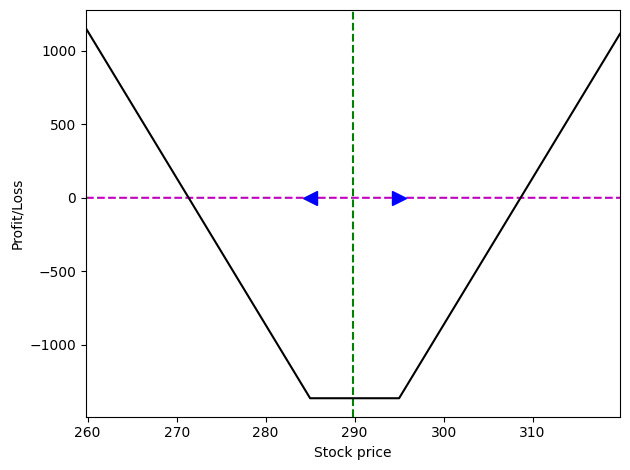

In [21]:
exp_strangle = exp_straddle
istrangle_call = get_index(atm_strike + spread, 'call', exp_strangle)
istrangle_put = get_index(atm_strike - spread, 'put', exp_strangle)
strangle = {
    'strategy': [
        {'type': 'call', 'strike': float(dfchain.loc[istrangle_call, 'strike']), 'premium': float(dfchain.loc[istrangle_call, 'ask']), 'n': 100, 'action': 'buy', 'expiration': exp_strangle},
        {'type': 'put', 'strike': float(dfchain.loc[istrangle_put, 'strike']), 'premium': float(dfchain.loc[istrangle_put, 'ask']), 'n': 100, 'action': 'buy', 'expiration': exp_strangle}
    ],
    'stock_price': float(underlying_price), 'volatility': volatility, 'interest_rate': interest_rate,
    'min_stock': min_stock, 'max_stock': max_stock, 'start_date': start_date, 'target_date': exp_strangle
}
sg = run_strategy(strangle)
plot_pl(sg)
print(sg)

## Final Comparison Table

In [22]:
strategy_summary = pd.DataFrame([
    {
        "Strategy": "Bull Put Spread",
        "Outlook": "Bullish",
        "Volatility Bias": "Stable or Falling",
        "Cost Type": "Credit",
        "Probability of Profit": round(bp.probability_of_profit, 2)
    },
    {
        "Strategy": "Bear Put Spread",
        "Outlook": "Bearish",
        "Volatility Bias": "Rising",
        "Cost Type": "Debit",
        "Probability of Profit": round(br.probability_of_profit, 2)
    },
    {
        "Strategy": "Iron Condor",
        "Outlook": "Neutral",
        "Volatility Bias": "Stable or Falling",
        "Cost Type": "Credit",
        "Probability of Profit": round(ic.probability_of_profit, 2)
    },
    {
        "Strategy": "Straddle",
        "Outlook": "Neutral / Big Move Expected",
        "Volatility Bias": "Rising",
        "Cost Type": "Debit",
        "Probability of Profit": round(sd.probability_of_profit, 2)
    },
    {
        "Strategy": "Strangle",
        "Outlook": "Neutral / Big Move Expected",
        "Volatility Bias": "Rising",
        "Cost Type": "Debit",
        "Probability of Profit": round(sg.probability_of_profit, 2)
    },
    {
        "Strategy": "Bull Call Spread",
        "Outlook": "Bullish",
        "Volatility Bias": "Rising",
        "Cost Type": "Debit",
        "Probability of Profit": round(bc.probability_of_profit, 2)
    },
    {
        "Strategy": "Bear Call Spread",
        "Outlook": "Bearish",
        "Volatility Bias": "Stable or Falling",
        "Cost Type": "Credit",
        "Probability of Profit": round(brc.probability_of_profit, 2)
    }
])

display(strategy_summary)

,Strategy,Outlook,Volatility Bias,Cost Type,Probability of Profit
0,Bull Put Spread,Bullish,Stable or Falling,Credit,0.58
1,Bear Put Spread,Bearish,Rising,Debit,0.51
2,Iron Condor,Neutral,Stable or Falling,Credit,0.32
3,Straddle,Neutral / Big Move Expected,Rising,Debit,0.28
4,Strangle,Neutral / Big Move Expected,Rising,Debit,0.27
5,Bull Call Spread,Bullish,Rising,Debit,0.48
6,Bear Call Spread,Bearish,Stable or Falling,Credit,0.52


In [23]:
def parse_strategy_output(output, label):
    lines = str(output).splitlines()
    result = {"Strategy": label}
    for line in lines:
        if "Probability of profit:" in line:
            result["Probability of Profit"] = float(line.split(":")[1].strip())
        elif "Strategy cost:" in line:
            result["Cost"] = float(line.split(":")[1].strip())
        elif "Profit ranges:" in line:
            result["Breakeven Range"] = line.split(":")[1].strip()
        elif "Maximum return" in line:
            result["Max Profit"] = line.split(":")[1].strip()
        elif "Minimum return" in line:
            result["Max Loss"] = line.split(":")[1].strip()
    return result

strategy_summary = pd.DataFrame([
    parse_strategy_output(bp, "Bull Put Spread"),
    parse_strategy_output(br, "Bear Put Spread"),
    parse_strategy_output(ic, "Iron Condor"),
    parse_strategy_output(sd, "Straddle"),
    parse_strategy_output(sg, "Strangle"),
    parse_strategy_output(bc, "Bull Call Spread"),
    parse_strategy_output(brc, "Bear Call Spread"),
])

display(strategy_summary)

,Strategy,Probability of Profit,Breakeven Range,Cost,Max Loss,Max Profit
0,Bull Put Spread,0.583849,"[(285.96, inf)]",305.0,-195.0,305.0
1,Bear Put Spread,0.513318,"[(0.0, 290.94)]",-405.0,-405.0,95.0
2,Iron Condor,0.324178,"[(281.46, 298.54)]",356.0,-144.00000000000023,355.9999999999999
3,Straddle,0.283458,"[(0.0, 271.68), (308.32, inf)]",-1830.0,-1830.0,1188.0000000000007
4,Strangle,0.274620,"[(0.0, 271.34), (308.66, inf)]",-1365.0,-1365.0,1153.0000000000007
5,Bull Call Spread,0.476578,"[(291.46, inf)]",-145.0,-145.0,355.0000000000002
6,Bear Call Spread,0.519151,"[(0.0, 291.24)]",125.0,-375.0000000000002,125.0
